In [2]:
# Synthetic Experiment for fairness 

# Load all necessary packages
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from utils import generate_data, generate_a_hat_indep_p, generate_a_hat, calc_assump_bounds, calculate_bias_metrics
sns.set_theme()

In [2]:
# Set the experiment
exp = 1

# Generate data
n = 5000
e1 = 1
e2 = 1
b = 0.05
group = 1
X, a, y_prob, y_hat, y  = generate_data(n,e1,e2,b,group,exp)
x1, x2, x3 = X[:,0], X[:,1], X[:,2]

# Organizing data
# using y
data = np.column_stack((x1,x2,x3,y_prob,y_hat,y,a))

# converting to dataframes
df = pd.DataFrame(data, columns = ['x1', 'x2', 'x3', 'y_prob', 'y_hat', 'y','a'])

# calculating base rates
r = df[(df['a'] == 1) & (df['y'] == 1)].shape[0]/df.shape[0]
s = df[(df['a'] == 0) & (df['y'] == 1)].shape[0]/df.shape[0]
v = df[(df['a'] == 1) & (df['y'] == 0)].shape[0]/df.shape[0]
w = df[(df['a'] == 0) & (df['y'] == 0)].shape[0]/df.shape[0]
min_rate = np.min([r,s,v,w])

# Calculate true bias_tpr and bias_fpr
alpha, beta, tau, phi = calculate_bias_metrics(df)
bias_tpr = np.abs(alpha - beta)
bias_fpr = np.abs(tau - phi)
print('abs_bias_tpr = ', bias_tpr)
print('abs_bias_fpr = ', bias_fpr)
print('min_rate = ', min_rate)

abs_bias_tpr =  0.04679999999999995
abs_bias_fpr =  0.09519999999999998
min_rate =  0.2342


In [3]:
# Calculating bounds for different errors of a_hat
# Consider a_hats that have errors that are normally distributed
k = 1000
p_errors = [0.05,0.15]
iter = 1000

# true bias
bias_t = [bias_tpr for i in range(iter)]
bias_f = [bias_fpr for i in range(iter)]

# List to append array of delta values for each p
delta_p_tpr = []
delta_p_fpr = []

for p_bar in p_errors:

    errors = []
    u_bound_t = []
    u_bound_f = []
    l_bound_t = []
    l_bound_f = []
    i = 0

    while i < iter:

        # Generate a_hat
        p = np.random.normal(p_bar,0.02)
        a_hat = generate_a_hat_indep_p(a,p)
        a_error = np.sum(a_hat != a)/a_hat.shape[0]
        if a_error >= min_rate:
            continue
        errors.append(a_error)

        # Using a_hat instead of a in the data
        # Using y
        data_ah = np.column_stack((x1,x2,x3,y_prob,y_hat,y,a_hat))

        # converting to dataframes (using a_hat)
        df_ah = pd.DataFrame(data_ah, columns = ['x1', 'x2', 'x3','y_prob','y_hat', 'y','a'])

        # Calculate est bias_tpr and bias_fpr
        alpha_hat, beta_hat, tau_hat, phi_hat = calculate_bias_metrics(df_ah)
        bias_est_tpr = np.abs(alpha_hat - beta_hat)
        bias_est_fpr = np.abs(tau_hat - phi_hat)

        # Computing the upper bound and lower bounds under the assumption
        k_1 = calc_assump_bounds(r,s,a_error,0.02)
        k_2 = calc_assump_bounds(v,w,a_error,0.02)
        u_bound_tpr = k_1*bias_est_tpr
        u_bound_fpr = k_2*bias_est_fpr
        l_bound_t.append(bias_est_tpr)
        l_bound_f.append(bias_est_fpr)
        u_bound_t.append(u_bound_tpr)
        u_bound_f.append(u_bound_fpr)

        i = i + 1

    # Calculate deltas 
    u_minus_b_tpr = np.abs(np.array(u_bound_t) - np.array(bias_tpr))
    b_tpr_minus_l = np.abs(np.array(bias_t) - np.array(l_bound_t))
    delta_p_tpr.append(np.maximum(u_minus_b_tpr,b_tpr_minus_l))

    u_minus_b_fpr = np.abs(np.array(u_bound_f) - np.array(bias_f))
    b_fpr_minus_l = np.abs(np.array(bias_f) - np.array(l_bound_f))
    delta_p_fpr.append(np.maximum(u_minus_b_fpr,b_fpr_minus_l))

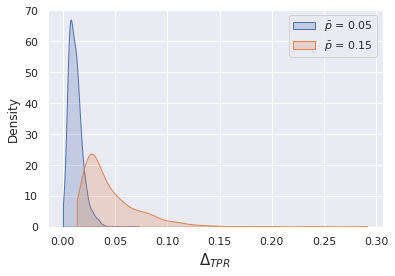

In [4]:
# Generate KDE Plots
sns.kdeplot(delta_p_tpr[0], shade = True, label = r'$\bar{p}$ = 0.05',cut = 0)
sns.kdeplot(delta_p_tpr[1], shade = True, label = r'$\bar{p}$ = 0.15',cut = 0)
plt.legend()
plt.xlabel(r'$\Delta_{TPR}$', fontsize=15)
plt.savefig('Figures/Exp1/assump_tpr_bound',bbox_inches="tight")

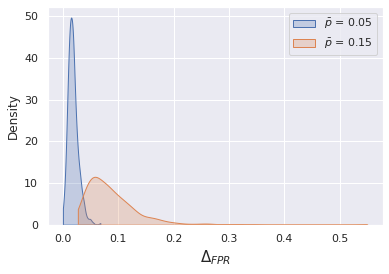

In [5]:
# Generate KDE Plots
sns.kdeplot(delta_p_fpr[0], shade = True, label = r'$\bar{p}$ = 0.05',cut = 0)
sns.kdeplot(delta_p_fpr[1], shade = True, label = r'$\bar{p}$ = 0.15',cut = 0)
plt.legend()
plt.xlabel(r'$\Delta_{FPR}$', fontsize=15)
plt.savefig('Figures/Exp1/assump_fpr_bound.png',bbox_inches="tight")